In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import platform
import matplotlib as mpl
import random
from copy import copy
import re

# if platform.system() == 'Darwin':
#     matplotlib.use("TkAgg")

import matplotlib.animation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import pprint

from pathlib import Path

from relnet.agent.baseline.baseline_agent import *
from relnet.agent.baseline.best_response_agent import *
from relnet.agent.baseline.simulated_annealing import *
from relnet.agent.mcts.mcts_agent import MonteCarloTreeSearchAgent
from relnet.agent.mcts.il.imitation_learning import *

from relnet.evaluation.storage import EvaluationStorage
from relnet.evaluation.file_paths import FilePaths
from relnet.visualization import *

exp_ids_ic_main = ['ggnn_main_15_ic', 'ggnn_main_25_ic', 'ggnn_main_50_ic', 'ggnn_main_75_ic', 'ggnn_main_100_ic']
exp_ids_ic_il = ['ggnn_ili_15_ic', 'ggnn_ili_25_ic', 'ggnn_ili_50_ic', 'ggnn_ili_75_ic', 'ggnn_ili_100_ic']
exp_ids_ic = exp_ids_ic_main + exp_ids_ic_il

exp_ids_hc_main = ['ggnn_main_15_hc', 'ggnn_main_25_hc', 'ggnn_main_50_hc', 'ggnn_main_75_hc', 'ggnn_main_100_hc']
exp_ids_hc_il = ['ggnn_ili_15_hc', 'ggnn_ili_25_hc', 'ggnn_ili_50_hc', 'ggnn_ili_75_hc', 'ggnn_ili_100_hc']              
exp_ids_hc = exp_ids_hc_main + exp_ids_hc_il

all_main_exps = exp_ids_ic_main + exp_ids_hc_main
all_il_exps = exp_ids_ic_il + exp_ids_hc_il
all_exp_ids = exp_ids_ic + exp_ids_hc

storage = EvaluationStorage()
fp = FilePaths('/experiment_data', 'aggregate', setup_directories=True)

filename_suffix = "final"

considered_agents_baseline = [
                        RandomAgent,
                        TargetHubsAgent,
                        TargetMinCostAgent,
                        ExhaustiveSearchAgent,
                        BestResponseAgent,
                        PayoffTransferAgent,
                        SimulatedAnnealingAgent,
]
considered_agents = [MonteCarloTreeSearchAgent, ImitationLearningAgent]

all_agents = considered_agents_baseline + considered_agents
display_order = [a.algorithm_name for a in all_agents]

network_generators = ['barabasi_albert', 'random_network', 'watts_strogatz']
network_sizes = [15, 25, 50, 75, 100]

excluded_agents = {'ic': [TargetMinCostAgent.algorithm_name],
                  'hc': []}

from copy import deepcopy

agents_no_exhaust = deepcopy(all_agents)
agents_no_exhaust.remove(ExhaustiveSearchAgent)
display_order_no_exhaust = [a.algorithm_name for a in agents_no_exhaust]


In [3]:
def fetch_results(exp_ids, agent_names, network_sizes, for_plot=False):
    all_result_dfs = []
    for exp_id in exp_ids:
        results = storage.get_evaluation_data(exp_id)
        experiment_details = storage.get_experiment_details(exp_id)
        hyps = storage.retrieve_optimal_hyperparams(exp_id, {}, experiment_details['experiment_conditions']['train_individually'])

        #print(f"optimal hyps for <<{exp_id}>> were:")
        # pprint.pprint(hyps)

        results_df = pd.DataFrame(results)
        results_df.dropna(inplace=True)
        
        results_df = results_df[results_df['network_generator'].isin(network_generators)]
        results_df = results_df[results_df['network_size'].isin(network_sizes)]
        results_df = results_df[results_df['algorithm'].isin(agent_names)]
              
        setting = 'ic' if 'ic' in exp_id else 'hc'
        results_df = results_df[~results_df['algorithm'].isin(excluded_agents[setting])]
        
        results_df['setting'] = [setting] * len(results_df)

        all_result_dfs.append(results_df)

    agg_df = pd.concat(all_result_dfs)
    if for_plot:
        agg_df.sort_values(by=['objective_function', 'network_generator'], inplace=True)
        agg_df['algorithm'] = pd.Categorical(agg_df['algorithm'], agent_names)
        agg_df.sort_values("algorithm")
    return agg_df

def create_pivot(results_df, all_agents, separate_sizes=False):
    nondet_agents = [a.algorithm_name for a in all_agents if not a.is_deterministic]
    nondet_idx = ['setting', 'network_generator', 'objective_function']
    if separate_sizes:
        nondet_idx.append('network_size')
    pivot = pd.pivot_table(results_df, values='cummulative_reward', 
                       index=nondet_idx, 
                       columns=['algorithm'],
                       aggfunc=np.mean)

    nondet_df = results_df[results_df['algorithm'].isin(nondet_agents)]
    nondet_means_df = pd.pivot_table(nondet_df, values='cummulative_reward', 
                           columns=['algorithm', 'agent_seed'], 
                           index=nondet_idx,                    
                           aggfunc=np.mean)

    format_ci_dict = {}
    for agent_name in nondet_agents:
        cis = nondet_means_df[agent_name].apply(compute_ci, axis=1)
        pivot[agent_name + "_ci"] = cis
        format_ci_dict[agent_name + "_ci"] = (lambda x: "±{:.3f}".format(abs(x)))

    format_ci_dict = {}
    for agent in all_agents:
        if agent.is_deterministic:
            continue
        agent_name = agent.algorithm_name
        cis = nondet_means_df[agent_name].apply(compute_ci, axis=1)
        pivot[agent_name + "_ci"] = cis
        format_ci_dict[agent_name + "_ci"] = (lambda x: "±{:.3f}".format(abs(x)))
        
    pivot.style.format("{:.3f}").format(format_ci_dict)
    return pivot
    
def clean_and_write_latex(pivot_table, all_agents, cols_order, filename, transpose=True, extra_replace_dict=None, separate_sizes=False, incl_cis=True):
    nondet_agents = [a.algorithm_name for a in all_agents if not a.is_deterministic]
    latex_df = pivot_table.copy()

    if incl_cis:
        for nondet_agent in nondet_agents:
            colname_ci = f"{nondet_agent}_ci"
            latex_df[nondet_agent] = latex_df.agg(lambda x: f"{x[nondet_agent]:.3f}±{x[colname_ci]:.3f}", axis=1)
            latex_df.drop(columns=[colname_ci], inplace=True)

    latex_df = latex_df[cols_order]
    row_maxes = latex_df.max(axis=1)

    repl_cols = copy(agent_display_names)
    repl_cols = {k:v for (k,v) in repl_cols.items() if not "UCT" in v}
    
    latex_df.rename(columns=repl_cols, inplace=True)

    texfile =  str(fp.figures_dir / filename)
    fh = open(texfile, 'w')
    if transpose:
        latex_df = latex_df.T
        latex_df.to_latex(buf=fh, float_format="{:0.3f}".format)
        fh.close()
    else:
        if separate_sizes:
            table_colformat = f"cccc{''.join(['c'] * len(cols_order)) }"
        else:
            table_colformat = f"ccc{''.join(['c'] * len(cols_order)) }"            
        latex_df.to_latex(buf=fh, float_format="{:0.3f}".format, column_format=table_colformat)
        fh.close()

    replace_dict = {
        r"uct\\_il": r"GIL (ours)",
        r"uct": r"UCT",
        r"setting": r"$\\mathbf{c}$",
        r"hc": r"HC",
        r"ic": r"IC",
        
        r"barabasi\\_albert" : r"BA",
        r"random\\_network" : r"ER",
        r"watts\\_strogatz" : r"WS",
        
        r"nan": r"---",
        r"objective\\_function": r"$f$",
        r"network\\_size" : r"$n$",
        r"network\\_generator" : r"$\\mathbf{G}$",
        r"algorithm" : r"",
        r"social\\_welfare": r"SW",
        r"fairness": r"F",
        r"±(\d+\.\d+)": r"\\tiny{$\\pm\g<1>$}"
    }
    
    if extra_replace_dict is not None:
        replace_dict.update(extra_replace_dict)

    with open(texfile, 'r') as f:
        raw_content = f.read()

    processed_content = raw_content
    for orig, targ in replace_dict.items():
        processed_content = re.sub(orig, targ, processed_content, flags = re.M)

    with open(texfile, 'w') as g:
        g.write(processed_content)
        
def get_highlight_maxes_dict(df):
    row_maxes = df.max(axis=1)
    maxes_dict = {}
    for row_max in row_maxes:
        replace_key = fr"{row_max:.3f}"
        replace_val = r"\\textbf{" + replace_key + "}"
        maxes_dict[replace_key] = replace_val
    return maxes_dict

def retrieve_il_hyp_data():
    all_eval_data_dfs = []

    for experiment_id in all_il_exps:
        param_spaces, df = storage.get_hyperparameter_optimisation_data(experiment_id, {}, train_individually=False)
        latest_experiment = storage.get_experiment_details(experiment_id)
        agent_names = latest_experiment["agents"]
        network_generators = latest_experiment["network_generators"]
        objective_functions = latest_experiment["objective_functions"]
        base_n = latest_experiment["experiment_conditions"]["base_n"]

        agent_name = ImitationLearningAgent.algorithm_name

        expanded_data = []
        for objective_function in objective_functions:
            subset = df[(df['agent_name'] == agent_name) & (df['objective_function'] == objective_function)]
            subset.drop(columns=['agent_name'])

            for idx, row in subset.iterrows():
                row_copy = dict(row)
                hyperparams_id = row['hyperparams_id']
                hyperparams = param_spaces[objective_function][agent_name][hyperparams_id]
                row_copy.update(hyperparams)
                row_copy['network_size'] = base_n
                expanded_data.append(row_copy)

        hyp_df = pd.DataFrame(expanded_data).drop(columns=['hyperparams_id'])
        setting = 'ic' if 'ic' in experiment_id else 'hc'
        hyp_df['setting'] = [setting] * len(hyp_df)
        all_eval_data_dfs.append(hyp_df)
    
    il_df = pd.concat(all_eval_data_dfs)
    il_df.sort_values(by=['objective_function', 'network_generator'], inplace=True)
    return il_df
        

# Individual Table, aggregated

In [4]:
results = fetch_results(all_exp_ids, display_order_no_exhaust, network_sizes=network_sizes)
pivot = create_pivot(results, agents_no_exhaust)
maxes_dict = get_highlight_maxes_dict(pivot)
clean_and_write_latex(pivot, agents_no_exhaust, display_order_no_exhaust, f'ggnn_results_{filename_suffix}.tex', transpose=False, extra_replace_dict=maxes_dict)

# Individual Table, separate (for appendix)

In [5]:
results = fetch_results(all_exp_ids, display_order_no_exhaust, network_sizes=network_sizes)
pivot = create_pivot(results, agents_no_exhaust, separate_sizes=True)
maxes_dict = get_highlight_maxes_dict(pivot)
clean_and_write_latex(pivot, agents_no_exhaust, display_order_no_exhaust, f'ggnn_full_results_{filename_suffix}.tex', transpose=False, extra_replace_dict=maxes_dict, separate_sizes=True)

# Win rate separate table

In [6]:
from collections import Counter
from random import Random
local_random = Random(42)


def win_agg(inner_slice):
    #print(inner_slice['cummulative_reward'].values)
    cr_vals = inner_slice['cummulative_reward'].values
    max_idx_rows = np.argwhere(cr_vals == np.amax(cr_vals)).flatten().tolist()

    if len(max_idx_rows) > 1:
        winner_idx = local_random.choice(max_idx_rows)
    else:
        winner_idx = max_idx_rows[0]

    winner = inner_slice.iloc[winner_idx]['algorithm']
    return winner

def wr_agg(data_slice):
    winners_df = data_slice.groupby(['agent_seed', 'network_seed']).apply(win_agg)
    win_counts = dict(Counter(winners_df.values))
    wc_keys = list(win_counts.keys())
    wc_vals = np.array(list(win_counts.values()))
    wc_sum = np.sum(wc_vals)

    win_pcs = list((wc_vals / wc_sum) * 100)
    for method in display_order_no_exhaust:
        if method not in excluded_agents[data_slice.iloc[0]['setting']]:
            if method not in wc_keys:
                wc_keys.append(method)
                win_pcs.append(0.)

    wr = pd.Series(dict(zip(wc_keys, win_pcs))).to_frame(0).T
    wr.reset_index(drop=True, inplace=True)

    return wr

wr_index = ['setting', 'network_generator', 'objective_function', 'network_size']
results = fetch_results(all_exp_ids, display_order_no_exhaust, network_sizes=network_sizes)
wr_tab = results.groupby(wr_index).apply(wr_agg)
wr_tab.index = wr_tab.index.droplevel(4)

maxes_dict = get_highlight_maxes_dict(wr_tab)
clean_and_write_latex(wr_tab, agents_no_exhaust, display_order_no_exhaust, f'ggnn_wr_results_{filename_suffix}.tex', transpose=False, extra_replace_dict=maxes_dict, separate_sizes=True, incl_cis=False)

# Main Results Plot

In [7]:
results = fetch_results(all_exp_ids, display_order, network_sizes=network_sizes, for_plot=True)
plot_size_based_results(results, fp.figures_dir / f'ggnn_network_size_all_{filename_suffix}.pdf', network_sizes=network_sizes)

/relnet/relnet/visualization.py:95: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  mpl.rcParams['text.latex.unicode'] = True


# Training curves

In [8]:
all_curve_dfs = []

exp_ids_curves = ['ggnn_ili_100_ic', 'ggnn_ili_100_hc']
agent_name = ImitationLearningAgent.algorithm_name

for exp_id in exp_ids_curves:
    experiment_details = storage.get_experiment_details(exp_id)
    fp_in = FilePaths('/experiment_data', exp_id, setup_directories=True)

    objective_functions = experiment_details['objective_functions']
    cost_setting = 'ic' if 'ic' in exp_id else 'hc'
    network_generators = experiment_details['network_generators']

    optimal_hyps = storage.retrieve_optimal_hyperparams(exp_id, {}, False)
    #print(optimal_hyps)

    for net_gen in network_generators:
        for obj_fun_name in objective_functions:
            experiment_conditions = experiment_details['experiment_conditions']
            steps_used = experiment_conditions['agent_budgets'][obj_fun_name][agent_name]
            model_seeds = experiment_conditions['experiment_params']['model_seeds']

            opt_hyps_setting = optimal_hyps[(net_gen, obj_fun_name, agent_name)]
            optimal_hyps_id = int(opt_hyps_setting[1])
            data_df = storage.fetch_all_eval_curves(agent_name, optimal_hyps_id, fp_in, objective_functions,
                                                                network_generators,
                                                                model_seeds,
                                                                train_individually=False
                                                            )

            data_df['setting'] = [cost_setting] * len(data_df)
            data_df_subset = data_df[(data_df['network_generator'] == net_gen) &
                                     (data_df['objective_function'] == obj_fun_name)]



            all_curve_dfs.append(data_df_subset)

agg_df = pd.concat(all_curve_dfs)
agg_df.sort_values(by=['objective_function', 'network_generator'], inplace=True)
eval_plot_filename = f'eval_curves_{agent_name}.pdf'
plot_eval_histories(agg_df, fp.figures_dir / eval_plot_filename)

/relnet/relnet/visualization.py:95: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  mpl.rcParams['text.latex.unicode'] = True


# Plot of timings

In [9]:
results = fetch_results(all_exp_ids, display_order, network_sizes=network_sizes, for_plot=True)
plot_timings(results, fp.figures_dir / f'ggnn_timings_{filename_suffix}.pdf', network_sizes=network_sizes)

/relnet/relnet/visualization.py:95: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  mpl.rcParams['text.latex.unicode'] = True


27417.947528560955


# Exploration of IL method hyperparameter

/relnet/relnet/visualization.py:95: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  mpl.rcParams['text.latex.unicode'] = True


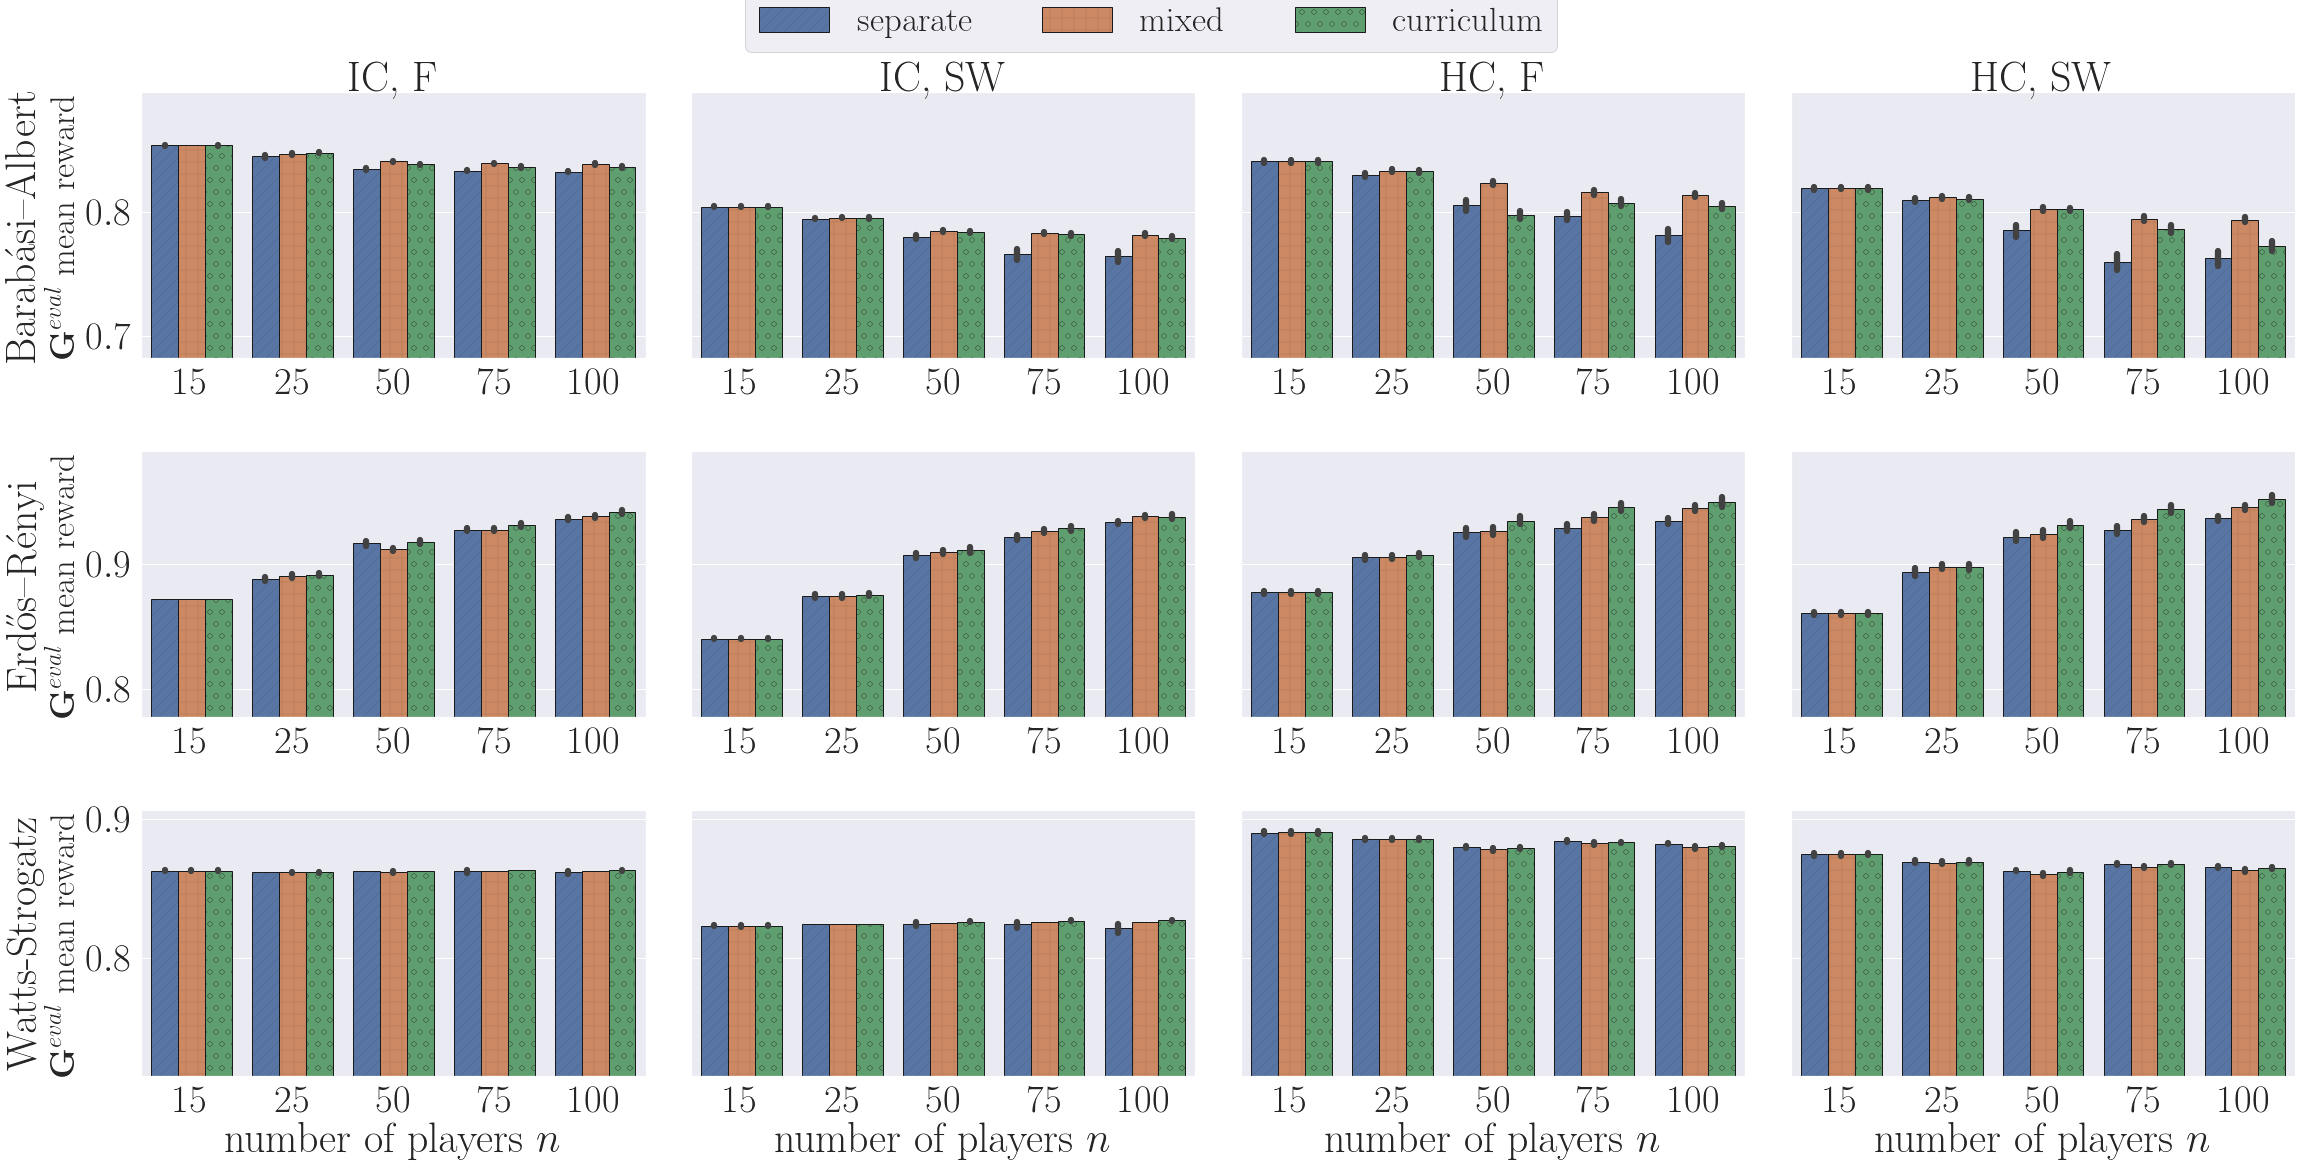

In [10]:
il_df = retrieve_il_hyp_data()
plot_il_method_data(il_df, fp.figures_dir / f'ggnn_il_method_{filename_suffix}.pdf')

# CSV table with hyperparameters

In [11]:
hyps_rows = []
relevant_hyps = {MonteCarloTreeSearchAgent.algorithm_name: {"C_p"},
                 ImitationLearningAgent.algorithm_name: {"learning_rate", "max_lv", "il_procedure"}
                }

for exp_id in all_exp_ids: 
    print(exp_id)
    experiment_details = storage.get_experiment_details(exp_id)
    gens = experiment_details['network_generators']
    objs = experiment_details['objective_functions']
    base_n = experiment_details['experiment_conditions']['base_n']
    setting = 'ic' if 'ic' in exp_id else 'hc'
    hyps = storage.retrieve_optimal_hyperparams(exp_id, {}, False)

    for gen in gens:
        for obj in objs:
            for agent in considered_agents:
                if (gen, obj, agent.algorithm_name) in hyps:
                    hyps_vals = hyps[(gen, obj, agent.algorithm_name)][0]

                    entry = {}
                    entry['network_generator'] = gen
                    entry['objective_function'] = obj
                    entry['algorithm'] = agent.algorithm_name
                    entry['network_size'] = base_n
                    entry['setting'] = setting
                    
                    for hyp_name in relevant_hyps[agent.algorithm_name]:
                        if hyp_name in hyps_vals:
                            entry[hyp_name] = str(hyps_vals[hyp_name])
                        else:
                            entry[hyp_name] = '---'
                    hyps_rows.append(entry)

ggnn_main_15_ic
ggnn_main_25_ic
ggnn_main_50_ic
ggnn_main_75_ic
ggnn_main_100_ic
ggnn_ili_15_ic
ggnn_ili_25_ic
ggnn_ili_50_ic
ggnn_ili_75_ic
ggnn_ili_100_ic
ggnn_main_15_hc
ggnn_main_25_hc
ggnn_main_50_hc
ggnn_main_75_hc
ggnn_main_100_hc
ggnn_ili_15_hc
ggnn_ili_25_hc
ggnn_ili_50_hc
ggnn_ili_75_hc
ggnn_ili_100_hc


In [12]:
mcts_df = pd.DataFrame([row for row in hyps_rows if row['algorithm'] == MonteCarloTreeSearchAgent.algorithm_name])
mcts_df.sort_values(by=['setting', 'network_generator', 'objective_function', 'network_size'], inplace=True)
mcts_df.to_csv(fp.figures_dir / f'mcts_hyps.csv', index=False)

In [13]:
il_df = pd.DataFrame([row for row in hyps_rows if row['algorithm'] == ImitationLearningAgent.algorithm_name])
il_df.sort_values(by=['setting', 'network_generator', 'objective_function', 'network_size'], inplace=True)
il_df.rename(columns={"max_lv": "K"}, inplace=True)
il_df.to_csv(fp.figures_dir / f'il_hyps.csv', index=False)